In [78]:
import os
import jax
import pickle
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

In [92]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "KF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WLF-MD": "gold",
    "KF-B": "darkorange",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
# file = "./results/2d-ssm-outlier-covariance.pkl"
file = "./results/2d-ssm-outlier-mean.pkl"
with open(file, "rb") as f:
    data = pickle.load(f)
name = data["name"].item()

In [173]:
data.keys()

dict_keys(['config', 'datasets', 'name', 'posterior-states', 'time'])

In [174]:
data["config"]

{'KF-B': {'alpha': array(1.41407565),
  'beta': array(0.04260884),
  'n_inner': array(2.40156147)},
 'KF-IW': {'n_inner': array(6.37193971), 'noise_scaling': array(15.84789958)},
 'WLF-IMQ': {'soft_threshold': array(3.62767164)},
 'WLF-MD': {'threshold': array(3.11248918)}}

## Plots

In [175]:
statev = data["datasets"]["latent"]
err_methods = jax.tree_map(lambda x: x - statev, data["posterior-states"])

In [176]:
diff_df = jax.tree_map(lambda x: np.sum(x ** 2, axis=1), err_methods)

diff_df = pd.concat([
    pd.DataFrame(diff_df[k]).reset_index().melt("index").assign(method=k)
    for k in diff_df
])
diff_df = diff_df.rename(
    {
        "variable": "state",
        "value": "error",
        "index": "trial"
    },
    axis=1
)
diff_df["kind"] = name

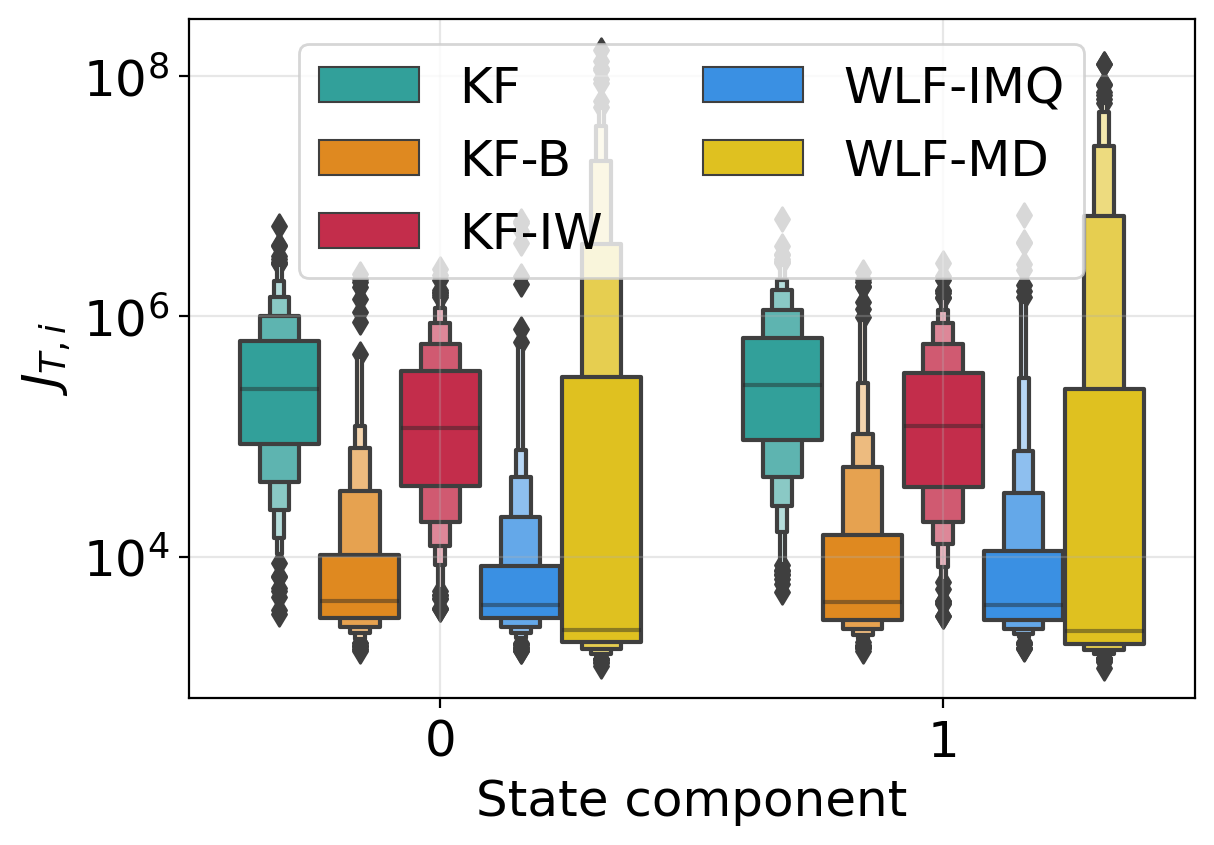

In [177]:
methods = sorted(diff_df.method.unique())
sns.boxenplot(
    y="error",
    x="state",
    hue="method",
    data=diff_df.query("state <= 1"),
    palette=cmap,
    hue_order=methods,
)
plt.legend(ncol=2)
plt.xlabel("State component")
plt.ylabel("$J_{T,i}$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.yscale("log")
plt.savefig(f"./figures/2d-ssm-comparison-outlier-{name}.png", dpi=300)

In [178]:
# remove first iteration (used to compile functions)
time_df = pd.DataFrame(data["time"]).iloc[1:]

In [179]:
((time_df / time_df["KF"].median(axis=0) - 1).describe().drop("KF", axis=1) * 100).T

,count,mean,std,min,25%,50%,75%,max
KF-B,49900.0,240.163220,109.523445,-99.532424,273.209870,275.123014,276.959044,280.470758
KF-IW,49900.0,384.777565,156.272651,-99.642586,431.904698,433.226028,436.955617,446.807755
WLF-IMQ,49900.0,-9.765319,28.954173,-99.717251,-1.199540,0.041617,0.296213,1.443120
WLF-MD,49900.0,-4.686131,30.624736,-99.711131,4.060075,5.220446,5.754119,9.498397


## Single model comparison

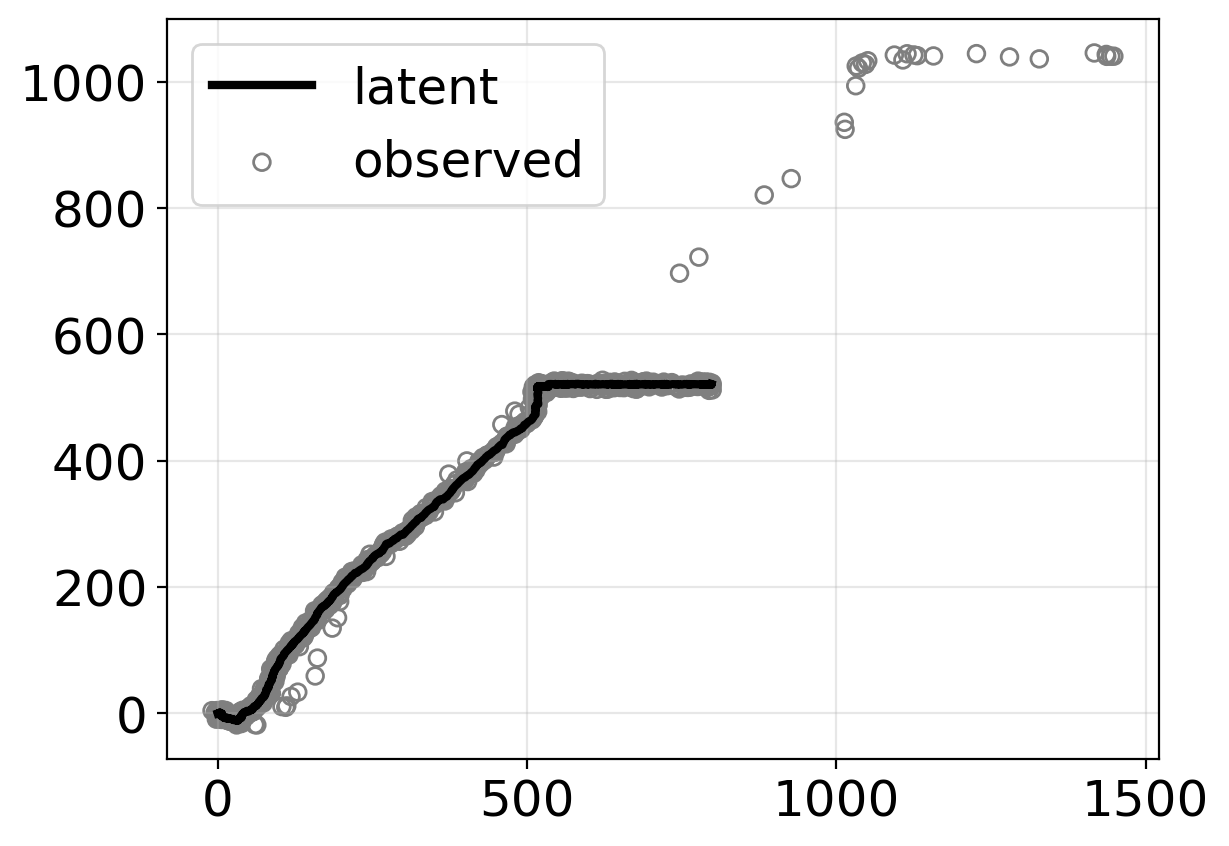

In [141]:
i = 11
# i = 2
latent_i = data["datasets"]["latent"][i, :, :2].T
observed_i = data["datasets"]["observed"][i]

plt.plot(*latent_i, c="black", label="latent", linewidth=3)
plt.scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed")
plt.legend()
plt.grid(alpha=0.3)

In [53]:
hist_runs = jax.tree_map(lambda x: x[i, :, :2], data["posterior-states"])

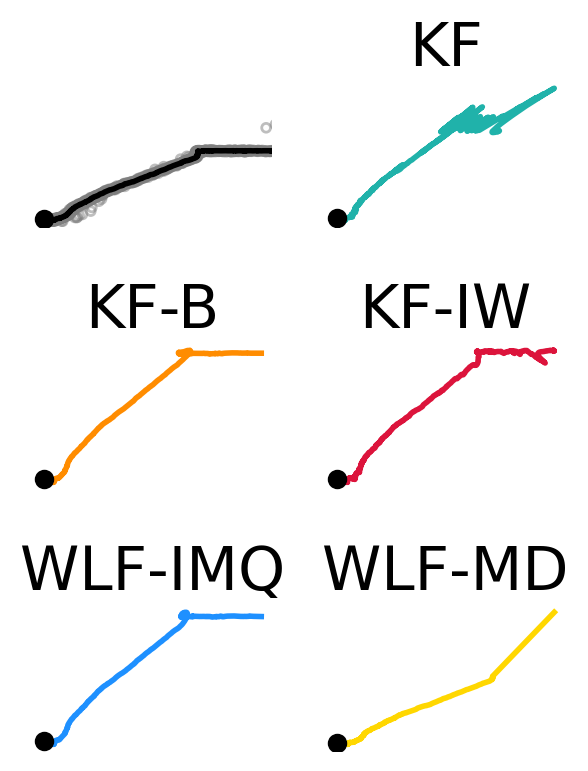

In [54]:
fig, axs = plt.subplots(3, 2, figsize=(6.4 * 0.5, 4.2))

for ax, key in zip(axs.ravel()[1:], hist_runs):
    state_est = hist_runs[key]
    ax.plot(*state_est.T, c=cmap[key], linewidth=2)
    ax.set_title(key)
    ax.axis("off")
    ax.scatter(0,0, c="black", zorder=3)
    
ylim = ax.get_ylim()
xlim = ax.get_xlim()

axs[0, 0].scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed", alpha=0.5, s=10)
axs[0, 0].plot(*latent_i, c="black", label="latent", linewidth=2.0)
axs[0, 0].axis("off")
axs[0, 0].scatter(0, 0, c="black", zorder=3)
axs[0, 0].set_ylim(*ylim)
axs[0, 0].set_xlim(*xlim)


plt.tight_layout()
# plt.savefig(f"./figures/2d-ssm-comparison-single-run-{name}.png", dpi=300)